In [1]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.linalg as dense_linalg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

# Set up example vector potential and magnetic field

Try sample problem of magnetic field from an infinite wire. 

Since I want to solve Laplace problem I will look at the current free area next to wire.

Set the wire centered at x=+15 and y=0 and radius 1.

### Rectilinear Mesh with equal spacing

In [2]:
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
z = np.linspace(-5, 5, 10)

mesh = np.meshgrid(x, y, z)
delta = x[1] - x[0]

In [3]:
x

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ])

### Analytic A and B field

In [4]:
r = np.sqrt((mesh[0]-15)**2. + mesh[1]**2.)
current = 1.
wire_radius = 1.  
mu_0 = 1.
A_x = np.zeros(mesh[0].shape)
A_y = np.zeros(mesh[0].shape)
A_z = -current*mu_0/(2.*np.pi)*np.log(r/wire_radius) 

theta = np.arctan2(mesh[1], mesh[0] - 15.)
B_x = mu_0*current/(2.*np.pi*r)*np.sin(theta)*-1
B_y = mu_0*current/(2.*np.pi*r)*np.cos(theta)
B_z = np.zeros(mesh[0].shape)

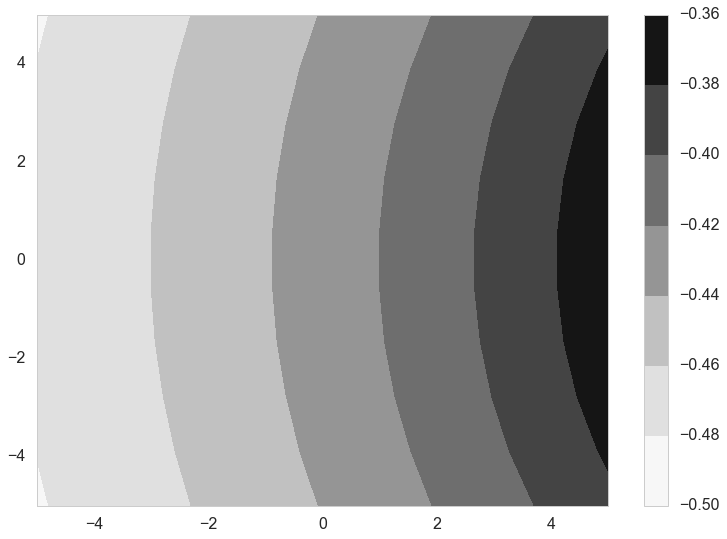

In [5]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], A_z[:,:,0])
plt.colorbar()

### Plot of B field

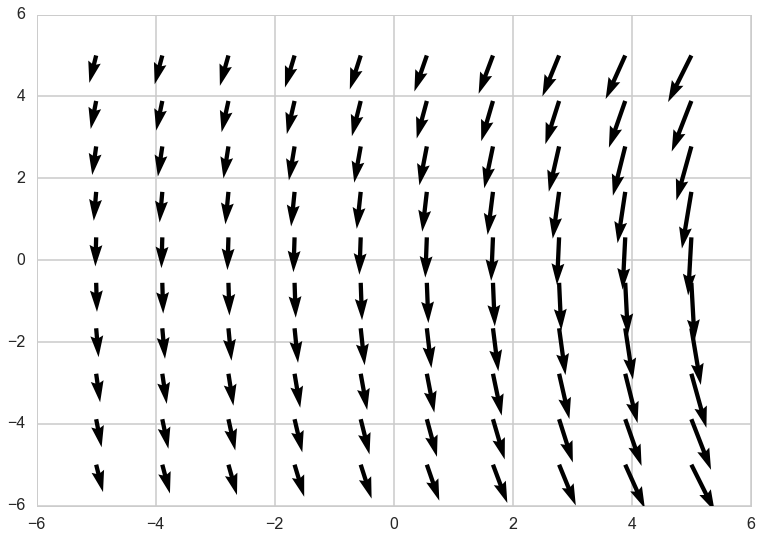

In [6]:
plt.quiver(mesh[0][:,:,0], mesh[1][:,:,0], B_x[:,:,0], B_y[:,:,0])

### Plot of B field from curl of A

In [7]:
def curl(vector, delta):
    vector_x_dx = np.gradient(vector[0], axis=1)*1./delta
    vector_x_dy = np.gradient(vector[0], axis=0)*1./delta
    vector_x_dz = np.gradient(vector[0], axis=2)*1./delta
    
    vector_y_dx = np.gradient(vector[1], axis=1)*1./delta
    vector_y_dy = np.gradient(vector[1], axis=0)*1./delta
    vector_y_dz = np.gradient(vector[1], axis=2)*1./delta
    
    vector_z_dx = np.gradient(vector[2], axis=1)*1./delta
    vector_z_dy = np.gradient(vector[2], axis=0)*1./delta
    vector_z_dz = np.gradient(vector[2], axis=2)*1./delta
    
    curl_x = vector_z_dy - vector_y_dz
    curl_y = vector_x_dz - vector_z_dx
    curl_z = vector_y_dx - vector_x_dy
    
    return [curl_x, curl_y, curl_z]

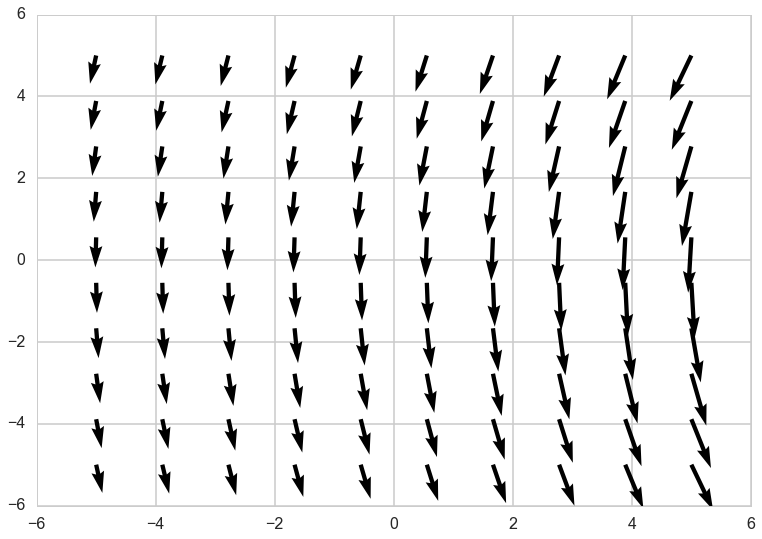

In [8]:
B_from_curl = curl([A_x, A_y, A_z], delta)
plt.quiver(mesh[0][:,:,0], mesh[1][:,:,0], B_from_curl[0][:,:,0], B_from_curl[1][:,:,0])

# Solve for A by solving Laplace equation

### Set up Laplace problem with Dirichlet boundaries

Build the matrix and b vector for the $Ax=b$ problem.

In [9]:
b_vector = np.zeros(A_z[1:-1, 1:-1, 1:-1].shape)
b_vector[0, :, :] += -A_z[0, 1:-1, 1:-1]
b_vector[:, 0, :] += -A_z[1:-1, 0, 1:-1]
b_vector[:, :, 0] += -A_z[1:-1, 1:-1, 0]
b_vector[-1, :, :] += -A_z[-1, 1:-1, 1:-1]
b_vector[:, -1, :] += -A_z[1:-1, -1, 1:-1]
b_vector[:, :, -1] += -A_z[1:-1, 1:-1, -1]
b_vector = b_vector.ravel()

In [10]:
shape_x = x[1:-1].shape
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), shape=(shape_x[0], shape_x[0]))
shape_y = y[1:-1].shape
matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), shape=(shape_y[0], shape_y[0]))
shape_z = z[1:-1].shape
matrix_z = sparse.diags((-2, 1, 1), (0, -1, 1), shape=(shape_z[0], shape_z[0]))

kron_x = sparse.kron(sparse.eye(matrix_z.shape[0]), sparse.eye(matrix_y.shape[0]))
kron_x = sparse.kron(kron_x, matrix_x)
kron_y = sparse.kron(sparse.eye(matrix_z.shape[0]), matrix_y)
kron_y = sparse.kron(kron_y, sparse.eye(matrix_x.shape[0]))
kron_z = sparse.kron(matrix_z, sparse.eye(matrix_y.shape[0]))
kron_z = sparse.kron(kron_z, sparse.eye(matrix_x.shape[0]))

matrix = kron_x + kron_y + kron_z

In [11]:
matrix.toarray()

array([[-6.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -6.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -6., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -6.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -6.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -6.]])

In [12]:
np.linalg.cond(matrix.toarray())

32.163437477526429

In [13]:
1/(np.finfo(x.dtype).eps)

4503599627370496.0

In [14]:
np.linalg.matrix_rank(matrix.toarray())

512

In [15]:
matrix.toarray().shape

(512, 512)

### Solve linear algebra equation 

In [16]:
shape = mesh[0][1:-1, 1:-1, 1:-1].shape
solution = dense_linalg.solve(matrix.toarray(), b_vector)
solution = solution.reshape(shape)

In [17]:
A_z_solved = np.array(A_z)
A_z_solved[1:-1, 1:-1, 1:-1] = solution

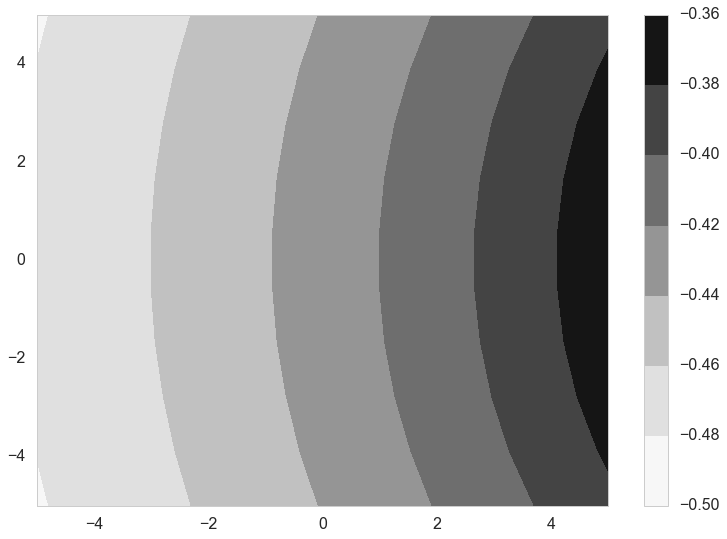

In [18]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], A_z_solved[:,:,0])
plt.colorbar()

### Test if curl of solution recovers B

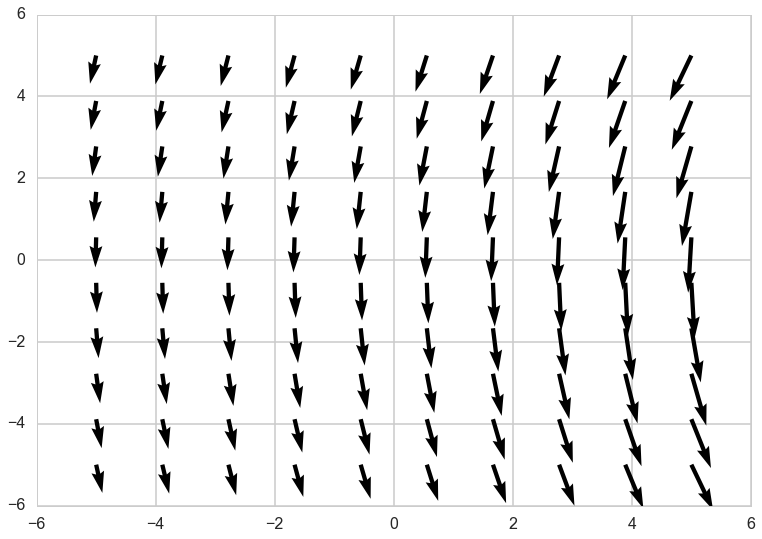

In [19]:
B_solved = curl([A_x, A_y, A_z_solved], delta)
plt.quiver(mesh[0][:,:,0], mesh[1][:,:,0], B_solved[0][:,:,0], B_solved[1][:,:,0])

In [20]:
np.sum((B_solved[0] - B_from_curl[0])**2)

7.9593492801400842e-09

In [21]:
np.sum((B_solved[1] - B_from_curl[1])**2)

1.2470811703979815e-08

# Now repeat with Neuman boundary conditions

Build the matrix and b vector for the $Ax=b$ problem.

In [22]:
b_vector = np.zeros(B_x.shape)
b_vector[0, :, :] += 2./delta*B_y[0, :, :]
b_vector[:, 0, :] += 2./delta*B_x[:, 0, :]
b_vector[:, :, 0] += 2./delta*B_z[:, :, 0]
b_vector[-1, :, :] += -2./delta*B_y[-1, :, :]
b_vector[:, -1, :] += -2./delta*B_x[:, -1, :]
b_vector[:, :, -1] += -2./delta*B_z[:, :, -1]
b_vector = b_vector.ravel()

In [406]:
shape_x = mesh[0].shape[1]
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape_x, shape_x))

for i, offset in enumerate(matrix_x.offsets):
    if offset == 0:
        matrix_x.data[i, offset] = -1.
        matrix_x.data[i, -1] = -1
    if offset < 0:
        matrix_x.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_x.data[i, offset] = 1.
matrix_x = matrix_x*1./delta**2.

shape = mesh[0].shape[0]
matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_y.offsets):
    if offset == 0:
        matrix_y.data[i, offset] = -1.        
        matrix_y.data[i, -1] = -1
    if offset < 0:
        matrix_y.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_y.data[i, offset] = 1.
matrix_y = matrix_y*1./delta**2.

shape_z = mesh[0].shape[2]
matrix_z = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape_z, shape_z))

for i, offset in enumerate(matrix_z.offsets):
    if offset == 0:
        matrix_z.data[i, offset] = -1.        
        matrix_z.data[i, -1] = -1
    if offset < 0:
        matrix_z.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_z.data[i, offset] = 1.
matrix_z = matrix_z*1./delta**2.


kron_x = sparse.kron(sparse.eye(matrix_z.shape[0]), sparse.eye(matrix_y.shape[0]))
kron_x = sparse.kron(kron_x, matrix_x)
kron_y = sparse.kron(sparse.eye(matrix_z.shape[0]), matrix_y)
kron_y = sparse.kron(kron_y, sparse.eye(matrix_x.shape[0]))
kron_z = sparse.kron(matrix_z, sparse.eye(matrix_y.shape[0]))
kron_z = sparse.kron(kron_z, sparse.eye(matrix_x.shape[0]))

matrix = kron_x + kron_y + kron_z

In [407]:
matrix.toarray()

array([[-2.43,  0.81,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.81, -3.24,  0.81, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.81, -3.24, ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.  ,  0.  ,  0.  , ..., -3.24,  0.81,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.81, -3.24,  0.81],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.81, -2.43]])

## The matrix is singular 

In [408]:
np.linalg.matrix_rank(matrix.toarray())

1999

In [409]:
np.linalg.cond(matrix.toarray())

83648127720615248.0

In [410]:
matrix.shape

(2000, 2000)

# Tie down one point

In [411]:
matrix_tie_down = sparse.csr_matrix(matrix)
matrix_tie_down.data[matrix.indptr[0]] = 1
matrix_tie_down.data[matrix.indptr[0]+1:matrix.indptr[1]] = 0
print matrix_tie_down.data[matrix.indptr[0]:matrix.indptr[1]]


b_vector_tie_down = np.array(b_vector)
b_vector_tie_down[0] = 0

[ 1.  0.  0.  0.]


## Solve Laplace 

In [412]:
shape = mesh[0].shape
solution = dense_linalg.solve(matrix_tie_down.toarray(), b_vector_tie_down)
solution = solution.reshape(shape)

In [413]:
scalar_potential = np.array(solution)
B_x_solved_neumann = np.gradient(scalar_potential, axis=1)*1./(delta)
B_y_solved_neumann = np.gradient(scalar_potential, axis=0)*1./(delta)
B_z_solved_neumann = np.gradient(scalar_potential, axis=2)*1./(delta)

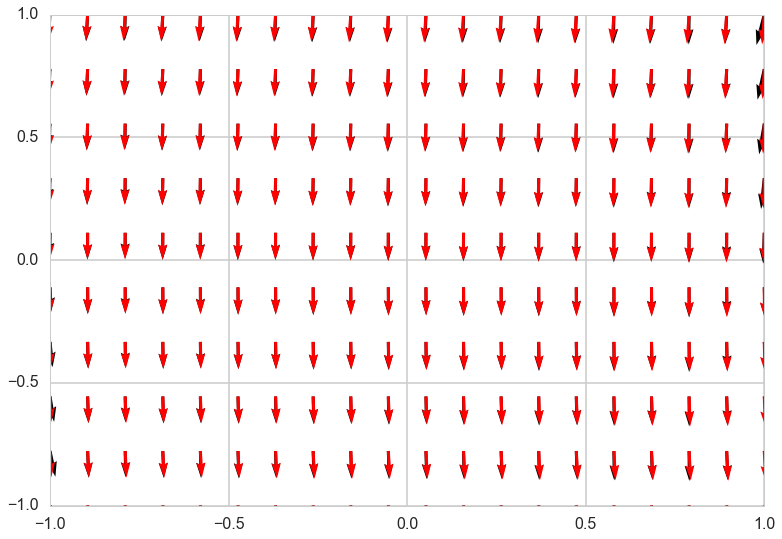

In [415]:
plt.quiver(mesh[0][:,:,0], mesh[1][:,:,0], 
           B_x_solved_neumann[:,:,0], 
           B_y_solved_neumann[:,:,0])
plt.quiver(mesh[0][:,:,0], mesh[1][:,:,0], 
           B_x[:,:,0], 
           B_y[:,:,0], color='red')

# Contour plots of the individual components look different too 

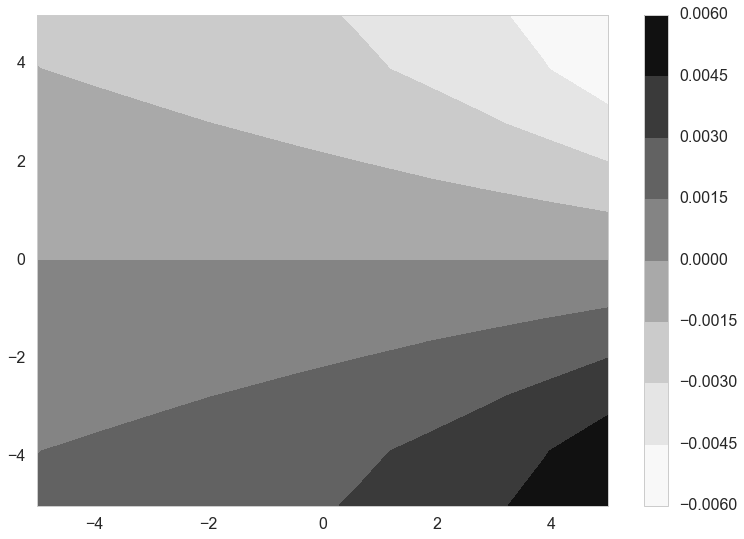

In [32]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], B_solved[0][:,:,0])
plt.colorbar()

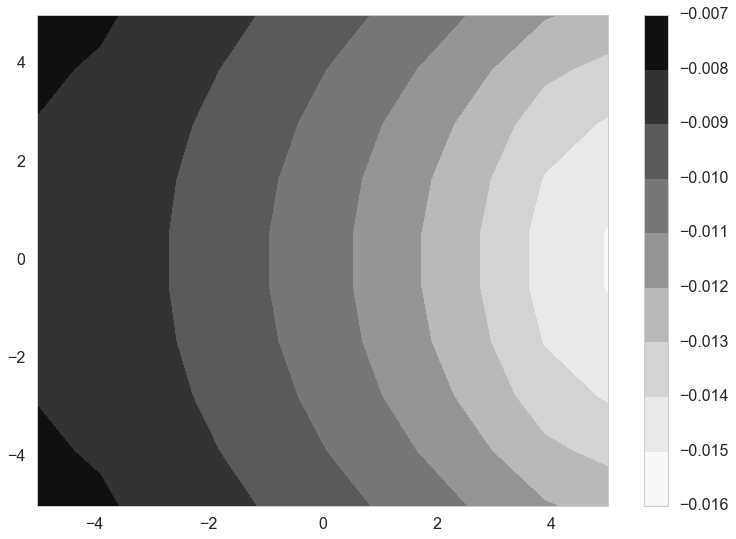

In [33]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], B_solved[1][:,:,0])
plt.colorbar()

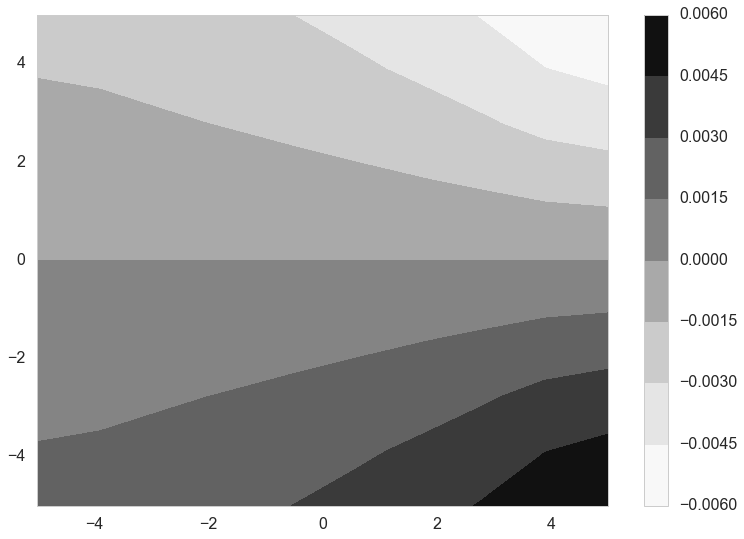

In [34]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], B_x_solved_neumann[:,:,0])
plt.colorbar()

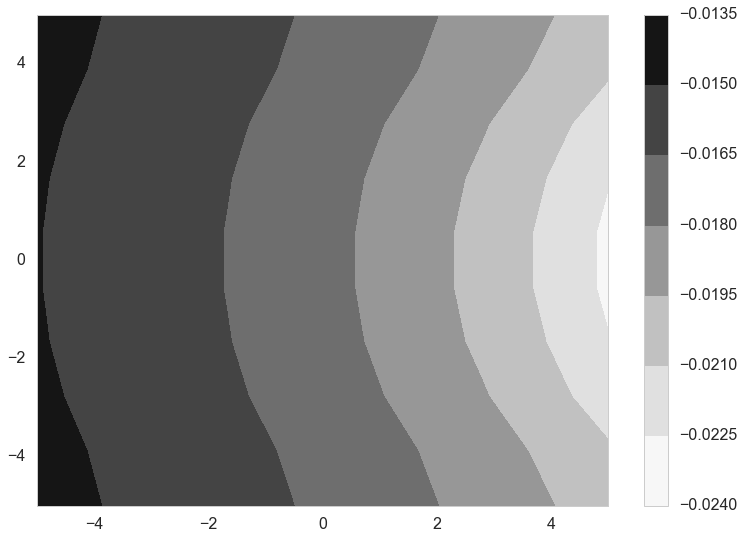

In [35]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], B_y_solved_neumann[:,:,0]-0.007)
plt.colorbar()

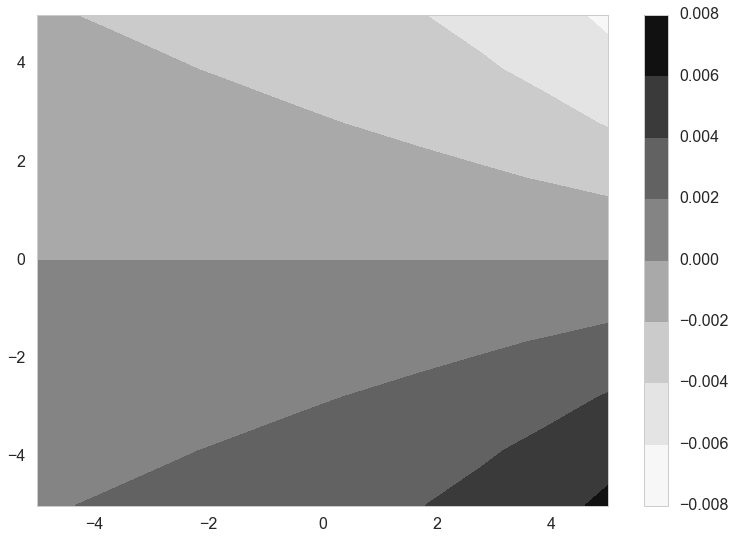

In [36]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], B_x[:,:,0])
plt.colorbar()

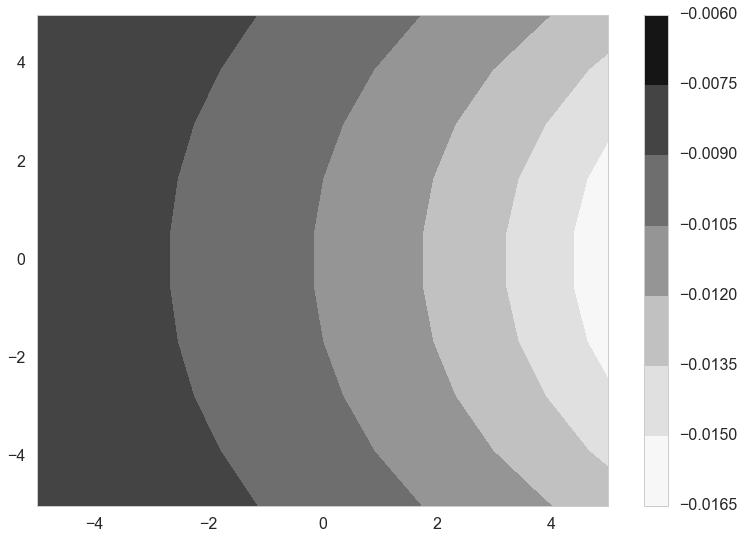

In [37]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], B_y[:,:,0])
plt.colorbar()

# Now try Neumann with uneven grid spacing

In [466]:
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
z = np.linspace(-1, 1, 20)

mesh = np.meshgrid(x, y, z)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
delta_z = z[1] - z[0]

In [467]:
r = np.sqrt((mesh[0]-15)**2. + mesh[1]**2.)
current = 1.
wire_radius = 1.  
mu_0 = 1.
A_x = np.zeros(mesh[0].shape)
A_y = np.zeros(mesh[0].shape)
A_z = -current*mu_0/(2.*np.pi)*np.log(r/wire_radius) 

theta = np.arctan2(mesh[1], mesh[0] - 15.)
B_x = mu_0*current/(2.*np.pi*r)*np.sin(theta)*-1
B_y = mu_0*current/(2.*np.pi*r)*np.cos(theta)
B_z = np.zeros(mesh[0].shape)

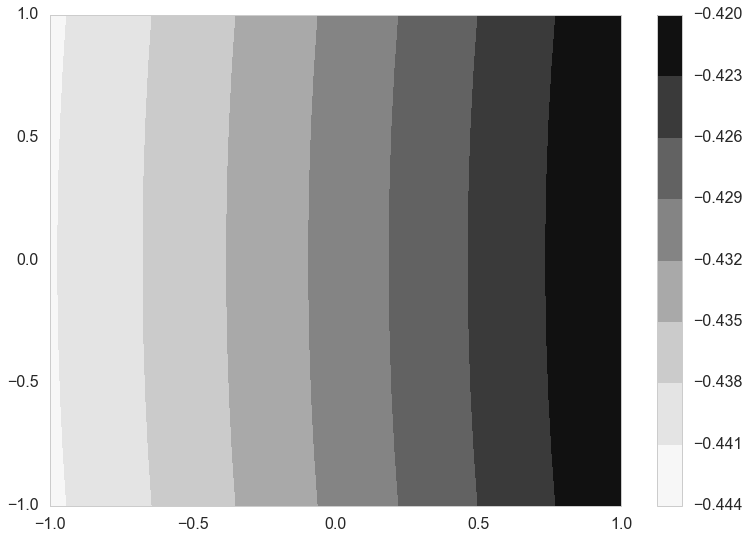

In [468]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], A_z[:,:,0])
plt.colorbar()

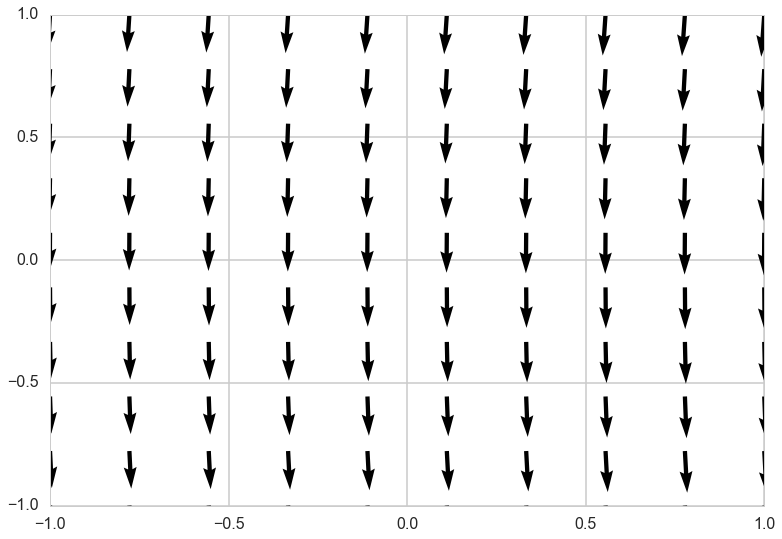

In [469]:
plt.quiver(mesh[0][:,:,0], mesh[1][:,:,0], B_x[:,:,0], B_y[:,:,0])

In [470]:
def curl(vector, delta):
    vector_x_dx = np.gradient(vector[0], axis=1)*1./delta_x
    vector_x_dy = np.gradient(vector[0], axis=0)*1./delta_y
    vector_x_dz = np.gradient(vector[0], axis=2)*1./delta_z
    
    vector_y_dx = np.gradient(vector[1], axis=1)*1./delta_x
    vector_y_dy = np.gradient(vector[1], axis=0)*1./delta_y
    vector_y_dz = np.gradient(vector[1], axis=2)*1./delta_z
    
    vector_z_dx = np.gradient(vector[2], axis=1)*1./delta_x
    vector_z_dy = np.gradient(vector[2], axis=0)*1./delta_y
    vector_z_dz = np.gradient(vector[2], axis=2)*1./delta_z
    
    curl_x = vector_z_dy - vector_y_dz
    curl_y = vector_x_dz - vector_z_dx
    curl_z = vector_y_dx - vector_x_dy
    
    return [curl_x, curl_y, curl_z]

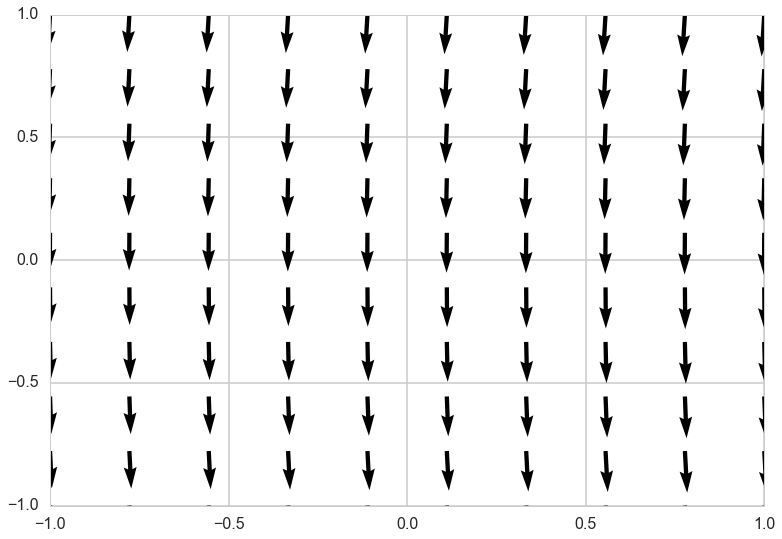

In [471]:
B_from_curl = curl([A_x, A_y, A_z], delta)
plt.quiver(mesh[0][:,:,0], mesh[1][:,:,0], B_from_curl[0][:,:,0], B_from_curl[1][:,:,0])

In [472]:
b_vector = np.zeros(B_x.shape)
b_vector[0, :, :] += 1./delta_y*B_y[0, :, :]
b_vector[:, 0, :] += 1./delta_x*B_x[:, 0, :]
b_vector[:, :, 0] += 1./delta_z*B_z[:, :, 0]
b_vector[-1, :, :] += -1./delta_y*B_y[-1, :, :]
b_vector[:, -1, :] += -1./delta_x*B_x[:, -1, :]
b_vector[:, :, -1] += -1./delta_z*B_z[:, :, -1]
b_vector = b_vector.ravel()

In [473]:
shape_x = mesh[0].shape[1]
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape_x, shape_x))

for i, offset in enumerate(matrix_x.offsets):
    if offset == 0:
        matrix_x.data[i, offset] = -1.
        matrix_x.data[i, -1] = -1
    if offset < 0:
        matrix_x.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_x.data[i, offset] = 1.
matrix_x = matrix_x*1./delta_x**2.

shape = mesh[0].shape[0]
matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_y.offsets):
    if offset == 0:
        matrix_y.data[i, offset] = -1.        
        matrix_y.data[i, -1] = -1
    if offset < 0:
        matrix_y.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_y.data[i, offset] = 1.
matrix_y = matrix_y*1./delta_y**2.

shape_z = mesh[0].shape[2]
matrix_z = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape_z, shape_z))

for i, offset in enumerate(matrix_z.offsets):
    if offset == 0:
        matrix_z.data[i, offset] = -1.        
        matrix_z.data[i, -1] = -1
    if offset < 0:
        matrix_z.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_z.data[i, offset] = 1.
matrix_z = matrix_z*1./delta_z**2.


kron_x = sparse.kron(sparse.eye(matrix_y.shape[0]), matrix_x)
kron_x = sparse.kron(sparse.eye(matrix_z.shape[0]), kron_x)
kron_y = sparse.kron(matrix_y, sparse.eye(matrix_x.shape[0]))
kron_y = sparse.kron(sparse.eye(matrix_z.shape[0]), kron_y)
kron_z = sparse.kron(matrix_z, sparse.eye(matrix_y.shape[0]))
kron_z = sparse.kron(kron_z, sparse.eye(matrix_x.shape[0]))

matrix = kron_x + kron_y + kron_z

In [474]:
matrix_tie_down = matrix.copy()
matrix_tie_down.data[matrix.indptr[0]] = 1
matrix_tie_down.data[matrix.indptr[0]+1:matrix.indptr[1]] = 0
print matrix_tie_down.data[matrix.indptr[0]:matrix.indptr[1]]


b_vector_tie_down = np.array(b_vector)
b_vector_tie_down[0] = 0

[ 1.  0.  0.  0.]


In [475]:
matrix_tie_down.toarray()

array([[   1.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [  20.25, -151.  ,   20.25, ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,   20.25, -151.  , ...,    0.  ,    0.  ,    0.  ],
       ..., 
       [   0.  ,    0.  ,    0.  , ..., -151.  ,   20.25,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,   20.25, -151.  ,   20.25],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,   20.25, -130.75]])

In [476]:
matrix_epsilon = matrix.copy()
matrix_epsilon = matrix_epsilon + sparse.eye(matrix_epsilon.shape[0])*1e-3

In [480]:
shape = mesh[0].shape
solution = dense_linalg.solve(matrix_tie_down.toarray(), b_vector_tie_down)
solution = solution.reshape(shape)

In [481]:
scalar_potential = np.array(solution)
B_x_solved_neumann = np.gradient(scalar_potential, axis=1)*1./(delta_x)
B_y_solved_neumann = np.gradient(scalar_potential, axis=0)*1./(delta_y)
B_z_solved_neumann = np.gradient(scalar_potential, axis=2)*1./(delta_z)

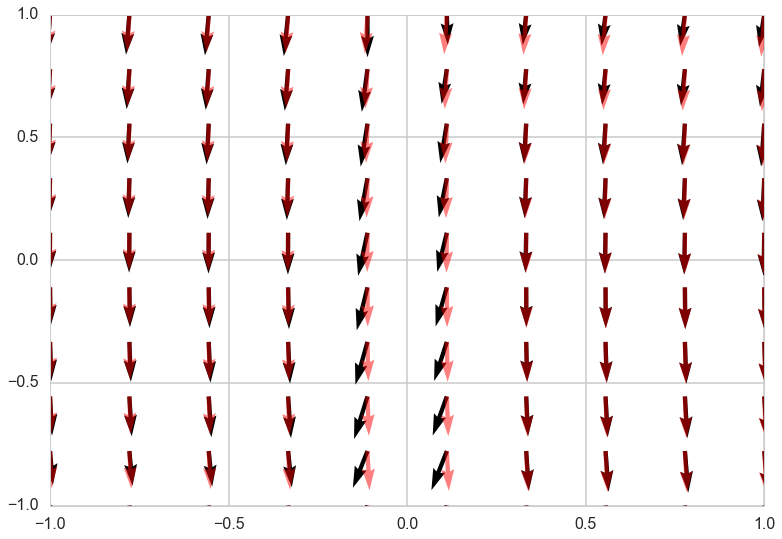

In [486]:
plt.quiver(mesh[0][:,:,5], mesh[1][:,:,5], 
           B_x_solved_neumann[:,:,0], 
           B_y_solved_neumann[:,:,0])
plt.quiver(mesh[0][:,:,10], mesh[1][:,:,10], 
           B_x[:,:,0], 
           B_y[:,:,0], color='red', alpha=0.5)

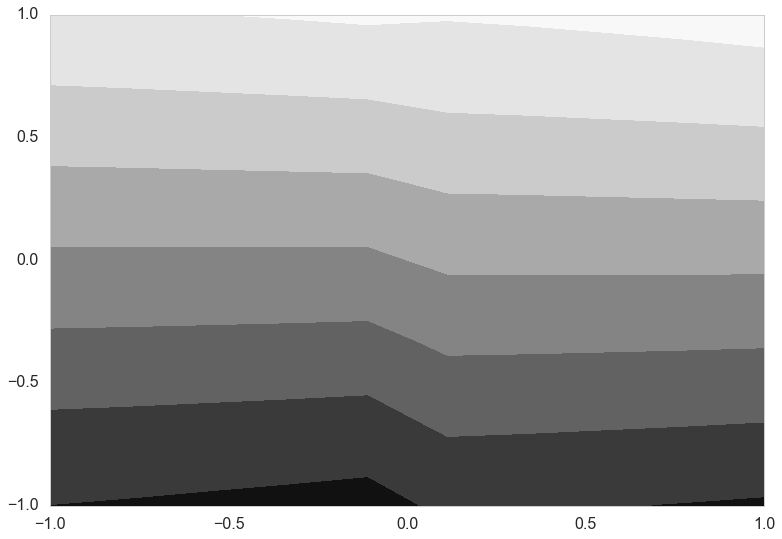

In [484]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], 
             scalar_potentialq[:,:,0])

# Test Matrix

In [393]:
shape_x = 20
shape_y = 20
shape_z = 4

delta_x, delta_y, delta_z = 1, 1, 1
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape_x, shape_x))
for i, offset in enumerate(matrix_x.offsets):
    if offset == 0:
        matrix_x.data[i, offset] = -1
        matrix_x.data[i, -1] = -1
    if offset < 0:
        matrix_x.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_x.data[i, offset] = 1.
matrix_x = matrix_x*1./delta_x**2.

matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape_y, shape_y))
for i, offset in enumerate(matrix_y.offsets):
    if offset == 0:
        matrix_y.data[i, offset] = -1
        matrix_y.data[i, -1] = -1
    if offset < 0:
        matrix_y.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_y.data[i, offset] = 1.
matrix_y = matrix_y*1./delta_y**2.

matrix_z = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape_z, shape_z))
for i, offset in enumerate(matrix_z.offsets):
    if offset == 0:
        matrix_z.data[i, offset] = -1
        matrix_z.data[i, -1] = -1
    if offset < 0:
        matrix_z.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_z.data[i, offset] = 1.
matrix_z = matrix_z*1./delta_z**2.

kron_x = sparse.kron(sparse.eye(matrix_y.shape[0]), matrix_x)
kron_x = sparse.kron(sparse.eye(matrix_z.shape[0]), kron_x)
kron_y = sparse.kron(matrix_y, sparse.eye(matrix_x.shape[0]))
kron_y = sparse.kron(sparse.eye(matrix_z.shape[0]), kron_y)
kron_z = sparse.kron(matrix_z, sparse.eye(matrix_y.shape[0]))
kron_z = sparse.kron(kron_z, sparse.eye(matrix_x.shape[0]))

matrix = kron_x + kron_y + kron_z

In [400]:
np.set_printoptions(linewidth=150)

In [401]:
matrix.toarray()

array([[-3.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -4., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -4.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -3.]])

In [402]:
matrix.toarray()[0,4]

0.0

In [403]:
matrix_x.toarray()

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  

In [404]:
matrix_y.toarray()

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  

In [399]:
matrix_z.toarray()

array([[-1.,  1.,  0.,  0.],
       [ 1., -2.,  1.,  0.],
       [ 0.,  1., -2.,  1.],
       [ 0.,  0.,  1., -1.]])